# Links between air pollution and COVID-19 in England #

### AIM 2: SUBREGIONAL LEVEL ANALYSIS

- [Creation of the dataset](#merged_covid_dt)
- [Data visualization](#datavis)
- [Link between COVID-19 deaths and air pollution: negative binomial fit](#nbf)
    - [pm10](#pm10)
    - [pm25](#pm25)
    - [nox](#nox)
    - [no2](#no2)
    - [o3](#o3)
    - [so2](#so2)
    - [models without Mean_ann_earnings](#mae)
    - [mortality rate](#or)
- [Link between COVID-19 cases and air pollution: negative binomial fit](#nbf_cases)
    - [distribution of cases](#vis_cases)
    - [pm10](#pm10_cases)
    - [pm25](#pm25_cases)
    - [nox](#nox_cases)
    - [no2](#no2_cases)
    - [o3](#o3_cases)
    - [so2](#so2_cases)
    - [infectivity rate](#or)
- [Link between COVID-19 deaths with 5 years pollution data](#nbf_5y)
- [Link between COVID-19 cases with 5 years pollution data](#nbf_cases_5y)

Import the modules I need for the analysis and the paths where the data are stores, all inclueded in the [conf_files](./conf_files.ipynb)

In [1]:
%run conf_files.ipynb

<a id='merged_covid_dt'></a>
### Creation of the dataset

Import the dataset needed for the subregional analysis (pop_dens, earning, age, covid_deaths). They are all descibed [here](../Data/datasets.ipynb)

In [2]:
pop_dens = pd.read_csv("%s/2018_official_popDensity.csv" %path)[['Code', '2018 people per sq. km']]
earning = pd.read_csv("%s/ann_earning_2018_perLA.csv" %path)[["Code","Mean_ann_earnings"]]
age = pd.read_csv("%s/processed_median_age_of_population_perLA.csv" %path)[["Code","median_age_2018","Name"]]
covid_deaths = pd.read_csv("%s/covid_deaths_until10April_byAreaCode.csv" %path)

Our interest is in the total number of deaths per subregion, no matter if in hospital at home or elsewhere. The covid_deaths dataset is then updated in order to contain a unique column representing the variable of interest, associated with the area code.

In [3]:
covid_deaths['total_deaths'] = covid_deaths['Home'] + covid_deaths['Hospital'] + covid_deaths['Care home'] + covid_deaths['Hospice'] + covid_deaths['Other communal establishment'] + covid_deaths['Elsewhere']
covid_deaths = covid_deaths[['Area code', 'total_deaths']]
columns=['Code', 'deaths']
covid_deaths.columns = columns
covid_deaths.head()

,Code,deaths
0,E06000001,20
1,E06000002,60
2,E06000003,26
3,E06000004,26
4,E06000005,14


A new dataset is created, by merging the informations contained in the datasets just imported. The aim is having a single dataset with the number of deaths, the mean annual earning, the median age, the population density, the area name and the area code.

In [4]:
all_data = [earning, age, pop_dens, covid_deaths]
merged_covid_dt = reduce(lambda left,right: pd.merge(left,right), all_data)
merged_covid_dt.sort_values(by='Code', inplace=True)
merged_covid_dt.head()

,Code,Mean_ann_earnings,median_age_2018,Name,2018 people per sq. km,deaths
1,E06000001,"25,985",41.8,Hartlepool,997,20
2,E06000002,"22,878",36.2,Middlesbrough,"2,608",60
3,E06000003,"23,236",45.0,Redcar and Cleveland,558,26
4,E06000004,"26,622",40.4,Stockton-on-Tees,962,26
0,E06000005,"26,908",43.1,Darlington,540,14


The commas in the '2018 people per sq. km' and 'Mean_ann_earnings' are deleted and the new dataset is saved as csv

In [5]:
merged_covid_dt['2018 people per sq. km'] = [x.replace(',','') for x in merged_covid_dt['2018 people per sq. km']]
merged_covid_dt['2018 people per sq. km'] = merged_covid_dt['2018 people per sq. km'].astype(int)
merged_covid_dt['Mean_ann_earnings'] = [x.replace(',','') for x in merged_covid_dt['Mean_ann_earnings']]
merged_covid_dt['Mean_ann_earnings'] = pd.to_numeric(merged_covid_dt['Mean_ann_earnings'],errors='coerce')
merged_covid_dt.to_csv('../data_out/merged_covid_dt.csv')

Data regarding pollutants are now requested. They are contained in the the dataset [covid_air_dt](../data_out/Output_data_des.ipynb). Its creation can be found [here](./covid_air_dt_creation.ipynb). 

In [6]:
covid_air_dt = pd.read_csv("../data_out/covid_air_dt.csv", na_values='x')
covid_air_dt.head()

,lon,lat,Code,deaths,X2018_people_per_sq_km,Mean_ann_earnings,median_age_2018,pm25_val,no2_val,o3_val,pm10_val,so2_val,nox_val
0,-1.209370,54.685728,E06000001,20,997,25985.0,41.8,7.362821,13.105737,5.303858,11.506778,1.575561,17.730895
1,-1.234405,54.576042,E06000002,60,2608,22878.0,36.2,8.210540,20.178191,4.251802,12.561928,3.133286,29.296034
2,-1.005496,54.567906,E06000003,26,558,23236.0,45.0,7.293137,7.749542,6.851500,12.855827,0.998864,9.983241
3,-1.312916,54.564094,E06000004,26,962,26622.0,40.4,7.900856,15.562038,5.050632,12.251130,1.934329,21.440737
4,-1.555581,54.524208,E06000005,14,540,26908.0,43.1,7.153221,11.360341,5.198811,11.129635,1.129034,15.098272


Only enghlish data are needed, that are the ones whose Code begins with an 'E'

In [7]:
covid_air_dt = covid_air_dt.loc[covid_air_dt['Code'].str.startswith('E')]

<a id='datavis'></a>
### Visualize the distribution of each variable

Variables of interest are standardized in order to visualize them all together.
The standardized version of the dataset is saved in covid_air_dt_vis

In [8]:
covid_air_dt_vis = covid_air_dt.loc[:,['deaths', 'X2018_people_per_sq_km',
       'Mean_ann_earnings', 'median_age_2018', 'pm25_val','no2_val','o3_val','pm10_val','so2_val','nox_val']]
for i in covid_air_dt_vis:
    covid_air_dt_vis[i] = (covid_air_dt_vis[i]-np.nanmean(covid_air_dt_vis[i]))/np.nanstd(covid_air_dt_vis[i])
covid_air_dt_vis
covid_air_dt_vis.head()

,deaths,X2018_people_per_sq_km,Mean_ann_earnings,median_age_2018,pm25_val,no2_val,o3_val,pm10_val,so2_val,nox_val
0,-0.505787,-0.306910,-0.583373,-0.040273,-0.986506,-0.088738,-0.702086,-0.970008,0.272117,-0.143747
1,0.284030,0.303208,-1.003121,-1.162510,-0.523774,0.940852,-1.010034,-0.574302,2.920669,0.830199
2,-0.387314,-0.473169,-0.954756,0.601006,-1.024543,-0.868480,-0.249075,-0.464083,-0.708422,-0.796208
3,-0.387314,-0.320166,-0.497316,-0.320832,-0.692817,0.268844,-0.776208,-0.690859,0.882120,0.168673
4,-0.624259,-0.479986,-0.458678,0.220247,-1.100917,-0.342829,-0.732834,-1.111445,-0.487099,-0.365451


The variable Code is added again and the dataset is melted and used for visualization

In [9]:
covid_air_dt_vis.loc[:,'Code']=covid_air_dt['Code']
covid_air_dt_vis_new=pd.melt(covid_air_dt_vis, id_vars='Code')
covid_air_dt_vis_new.head()

,Code,variable,value
0,E06000001,deaths,-0.505787
1,E06000002,deaths,0.284030
2,E06000003,deaths,-0.387314
3,E06000004,deaths,-0.387314
4,E06000005,deaths,-0.624259


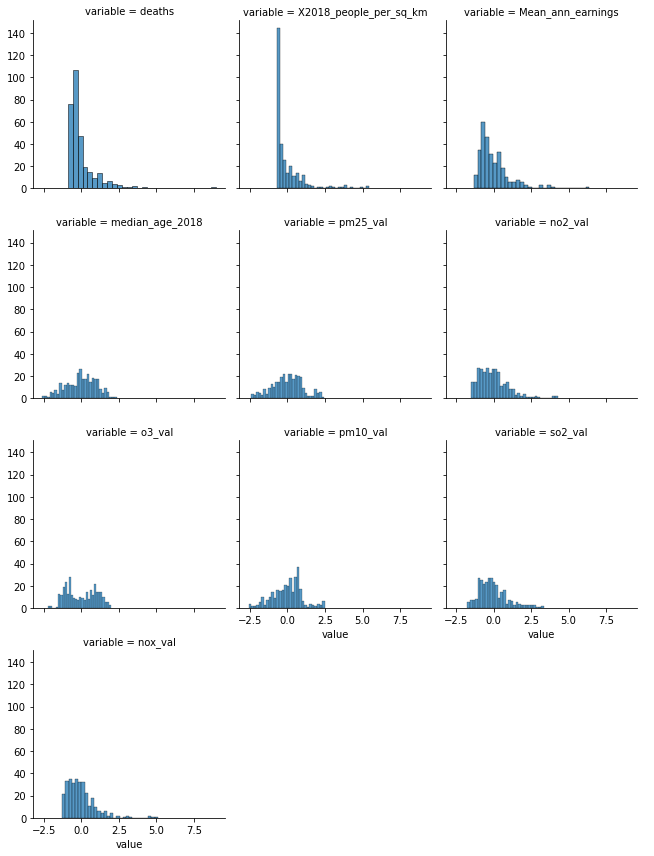

In [10]:
g = sns.FacetGrid(covid_air_dt_vis_new, col='variable', col_wrap=3)
g.map(sns.histplot, 'value', bins=30)
g.add_legend()

From the plot we can see thah
- all pollutants seem to have very different value according to the location
- population density and number of deaths have similar distribution, skewed on the right
- mean annual earning has similar distribution to deaths and number of deaths but less skewed

<a id='nbf'></a>
### Fit negative binomial regression model with number of deaths as dependent variable

<a id='pm10'></a>
##### Investigate the impact of particulate matter with an aerodynamic diameter < 10.0 μm (pm10) on the expected number of deaths
Here a negative binomial regression model is fitted. The number of deaths is the dependent variable and the value of pm10 is used as regressor. Population density, mean annual earnings and median age are included in the model to account for their counfonding effect.

In [11]:
pm10_deaths = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm10_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4741584)).fit()
print(pm10_deaths.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm10_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_pm10 = pd.DataFrame()
vif_deaths_pm10['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_pm10['variable'] = X.columns
print(vif_deaths_pm10)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  306
Model:                            GLM   Df Residuals:                      301
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1393.3
Date:                Fri, 01 Oct 2021   Deviance:                       326.88
Time:                        22:27:49   Pearson chi2:                     358.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

pm10_val and Mean_ann_earnings are not statistically significant. 
The variance inflation factor is computed. It measures how much the variance (or standard error) of the estimated regression coefficient is inflated due to collinearity. There is no evident collinearity.

<a id='pm25'></a>
##### Investigate the impact of particular matter with an aerodynamic diameter < 2.5 μm (pm25) on the expected number of deaths
Here a nagative binomial regression model is fitted. The number of deaths is the dependent variable and the value of pm25 is used as regressor. Population density, mean annual earnings and median age are included in the model to account for their counfonding effect.

In [12]:
pm25_deaths = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm25_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha = 0.4764173)).fit()
print(pm25_deaths.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm25_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_pm25 = pd.DataFrame()
vif_deaths_pm25['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_pm25['variable'] = X.columns
print(vif_deaths_pm25)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  306
Model:                            GLM   Df Residuals:                      301
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1394.3
Date:                Fri, 01 Oct 2021   Deviance:                       327.58
Time:                        22:27:54   Pearson chi2:                     361.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

Similar as before, mean annual earnings is not statistically significant and neither pm25_value. There is no collinearity.

<a id='nox'></a>
##### Investigate the impact of nitrogen oxides (nox) on the expected number of deaths
Here a nagative binomial regression model is fitted. The number of deaths is the dependent variable and the value of nox is used as regressor. Population density, mean annual earnings and median age are included in the model to account for their counfonding effect.

In [13]:
nox_deaths = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + nox_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4666356)).fit()
print(nox_deaths.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + nox_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_nox = pd.DataFrame()
vif_deaths_nox['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_nox['variable'] = X.columns
print(vif_deaths_nox)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  306
Model:                            GLM   Df Residuals:                      301
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1391.3
Date:                Fri, 01 Oct 2021   Deviance:                       327.84
Time:                        22:27:57   Pearson chi2:                     392.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

Mean_ann_earnings is not statistically significant.
The variable nox has a significant effect on the number of deaths. 
There is not collinearity

<a id='no2'></a>
##### Investigate the impact of nitrogen dioxide (NO2) on the expected number of deaths
Here a nagative binomial regression model is fitted. The number of deaths is the dependent variable and the value of NO2 is used as regressor. Population density, mean annual earnings and median age are included in the model to account for their counfonding effect.

In [14]:
no2_deaths = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + no2_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha = 0.4636069)).fit()
print(no2_deaths.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + no2_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_no2 = pd.DataFrame()
vif_deaths_no2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_no2['variable'] = X.columns
print(vif_deaths_no2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  306
Model:                            GLM   Df Residuals:                      301
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1390.3
Date:                Fri, 01 Oct 2021   Deviance:                       327.81
Time:                        22:27:59   Pearson chi2:                     402.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

Mean_ann_earnings is not statistically significant. 
no2_val has a significant effect. 
There is no collinearity

<a id='o3'></a>
##### Investigate the impact of ozone (O3) on the expected number of deaths
Here a nagative binomial regression model is fitted. The number of deaths is the dependent variable and the value of O3 is used as regressor. Population density, mean annual earnings and median age are included in the model to account for their counfonding effect.

In [15]:
o3_deaths = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + o3_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4668534)).fit()
print(o3_deaths.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + o3_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_o3 = pd.DataFrame()
vif_deaths_o3['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_o3['variable'] = X.columns
print(vif_deaths_o3)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  306
Model:                            GLM   Df Residuals:                      301
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1390.7
Date:                Fri, 01 Oct 2021   Deviance:                       326.43
Time:                        22:28:02   Pearson chi2:                     365.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

only Mean_ann_earnings is not statistically significant. O3 is significant. There is no collinearity.

<a id='so2'></a>
##### investigate the impact of Sulfur dioxide (SO2) on the expected number of deaths
Here a nagative binomial regression model is fitted. deaths is the dependent variable and the value of SO2 is used as regressor. Population density, mean annual earnings and median age are included in the model to account for their counfonding effect.

In [16]:
so2_deaths = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + so2_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4697041)).fit()
print(so2_deaths.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + so2_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_so2 = pd.DataFrame()
vif_deaths_so2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_so2['variable'] = X.columns
print(vif_deaths_so2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  306
Model:                            GLM   Df Residuals:                      301
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1390.9
Date:                Fri, 01 Oct 2021   Deviance:                       325.01
Time:                        22:28:04   Pearson chi2:                     396.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

Mean_ann_earnings is not significant. There is no collinearity

<a id='mae'></a>
##### Fit the same models without the variable Mean_ann_earnings because not significant

In [17]:
o3_deaths_nb_red = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + median_age_2018 + o3_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4621072)).fit()
print(o3_deaths_nb_red.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + o3_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_nb_red_pm10 = pd.DataFrame()
vif_deaths_nb_red_pm10['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_nb_red_pm10['variable'] = X.columns

so2_deaths_nb_red = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + median_age_2018 + so2_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4638219)).fit()
print(so2_deaths_nb_red.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + so2_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_nb_red_so2 = pd.DataFrame()
vif_deaths_nb_red_so2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_nb_red_so2['variable'] = X.columns

no2_deaths_nb_red = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + median_age_2018 + no2_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4582951)).fit()
print(no2_deaths_nb_red.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + no2_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_nb_red_no2 = pd.DataFrame()
vif_deaths_nb_red_no2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_nb_red_no2['variable'] = X.columns

nox_deaths_nb_red = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + median_age_2018 + nox_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.461042)).fit()
print(nox_deaths_nb_red.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + nox_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_nb_red_nox = pd.DataFrame()
vif_deaths_nb_red_nox['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_nb_red_nox['variable'] = X.columns

pm25_deaths_nb_red = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + median_age_2018 + pm25_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4701457)).fit()
print(pm25_deaths_nb_red.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm25_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_nb_red_pm25 = pd.DataFrame()
vif_deaths_nb_red_pm25['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_nb_red_pm25['variable'] = X.columns

pm10_deaths_nb_red = smf.glm(formula = "deaths ~ X2018_people_per_sq_km + median_age_2018 + pm10_val", data=covid_air_dt, family=sm.families.NegativeBinomial(alpha=0.4686036)).fit()
print(pm10_deaths_nb_red.summary())
y, X = dmatrices('deaths ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm10_val', data=covid_air_dt, return_type='dataframe')
vif_deaths_nb_red_pm10 = pd.DataFrame()
vif_deaths_nb_red_pm10['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_nb_red_pm10['variable'] = X.columns

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  312
Model:                            GLM   Df Residuals:                      308
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1416.9
Date:                Fri, 01 Oct 2021   Deviance:                       332.94
Time:                        22:28:21   Pearson chi2:                     368.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

All the regressors in every model are significant, except for pm10_value and pm25_value

The computed models are saved in a html file:

In [19]:
nb2018_deaths = Stargazer([pm10_deaths_nb_red, pm25_deaths_nb_red, nox_deaths_nb_red, no2_deaths_nb_red, o3_deaths_nb_red, so2_deaths_nb_red])
nb2018_deaths.custom_columns(['pm10', 'pm25', 'nox', 'no2', 'o3', 'so2'], [1,1,1,1,1,1])
html = open("../data_out/negative_binomial_deaths_2018.html","w")
html.write(nb2018_deaths.render_html())
html.close()

<a id='or'></a>
##### Mortality rate: compute and visualize odds ratio

In [21]:
deaths_pm10_or = pd.concat([np.exp(pm10_deaths.params),np.exp(pm10_deaths.conf_int()[0]),np.exp(pm10_deaths.conf_int()[1]),pm10_deaths.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_o3_or = pd.concat([np.exp(o3_deaths.params),np.exp(o3_deaths.conf_int()[0]),np.exp(o3_deaths.conf_int()[1]),o3_deaths.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_no2_or = pd.concat([np.exp(no2_deaths.params),np.exp(no2_deaths.conf_int()[0]),np.exp(no2_deaths.conf_int()[1]),no2_deaths.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_nox_or = pd.concat([np.exp(nox_deaths.params),np.exp(nox_deaths.conf_int()[0]),np.exp(nox_deaths.conf_int()[1]),nox_deaths.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_pm25_or = pd.concat([np.exp(pm25_deaths.params),np.exp(pm25_deaths.conf_int()[0]),np.exp(pm25_deaths.conf_int()[1]),pm25_deaths.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
LA_covid_onlyPoll = pd.concat([deaths_pm10_or.iloc[deaths_pm10_or.shape[0]-1],
                               deaths_o3_or.iloc[deaths_o3_or.shape[0]-1],
                               deaths_no2_or.iloc[deaths_no2_or.shape[0]-1],
                               deaths_nox_or.iloc[deaths_nox_or.shape[0]-1],
                               deaths_pm25_or.iloc[deaths_pm25_or.shape[0]-1]], axis=1)
LA_covid_onlyPoll = LA_covid_onlyPoll.transpose()
LA_covid_onlyPoll['significance'] = np.where(LA_covid_onlyPoll['pvalue'] < 0.05, 'p-value < 0.05', 'p-value > 0.05')
LA_covid_onlyPoll['names'] = LA_covid_onlyPoll.index.values 
LA_covid_onlyPoll = LA_covid_onlyPoll.sort_values(by=['or'], ascending = False)
LA_covid_onlyPoll.to_csv("../data_out/LA_covid_DEATHS_onlyPoll_preL_AP2018.csv")
LA_covid_onlyPoll

,or,0.025,0.975,pvalue,significance,names
no2_val,1.031118,1.011296,1.051329,0.001973,p-value < 0.05,no2_val
nox_val,1.016822,1.005656,1.028112,0.003065,p-value < 0.05,nox_val
o3_val,0.960700,0.937143,0.984850,0.001550,p-value < 0.05,o3_val
pm10_val,0.960271,0.924077,0.997883,0.038633,p-value < 0.05,pm10_val
pm25_val,0.957048,0.900861,1.016740,0.154975,p-value > 0.05,pm25_val


From this table we can easily see the impact of the pollutants on the expected number of deaths. pm10 and pm25 cannote be interpreted as their pvalue is greater than 0.05, inducating that they are not significant predictors of the number of COVID-19-related deaths based on 2018 air pollution data. 

no2 and nox are risk factor while o3 is a protective factor.

For a unit increase of nitrogen dioxide (no2) the expected number of deaths increases by 3%.
For a unit increase of nitrogen oxode (nox) the expected number of deaths increases by 1.6%.
For a uinit increase of ozone (o3) the expected number of deaths decreases by 4%.

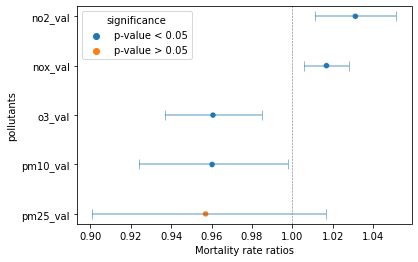

In [22]:
ax = sns.scatterplot(x="or", y="names", data=LA_covid_onlyPoll, hue="significance")
plt.axvline(x=1,linestyle ="--", linewidth=0.6, color = 'gray')
xerr = [abs(LA_covid_onlyPoll['or'].values-LA_covid_onlyPoll['0.025'].values),abs(LA_covid_onlyPoll['or'].values-LA_covid_onlyPoll['0.975'].values)]
plt.errorbar(LA_covid_onlyPoll['or'], LA_covid_onlyPoll['names'], xerr = xerr, fmt = 'none', capsize=5, alpha=0.5)
plt.xlabel("Mortality rate ratios")
plt.ylabel("pollutants")
plt.savefig('../data_out/mortality_rate_2018.png')
plt.show()

<a id='nbf_cases'></a>
### Fit negative binomial regression model with number of cases as dependent variable

The same analysis is now performed to study the relationship between number of cases and pollution levels.

Information regarding cases can be found in the [cases_LA_dt_raw](../Data/datasets.ipynb#cases_LA_dt_raw]). By manipulating this dataset a new dataset, cases_LA_dt.agg, is obtained. It shows the mean value of lab-confirmed cases grouped by area code
<a id='agg'></a>

In [23]:
cases_LA_raw = pd.read_csv("%s/coronavirus-cases_latest-18_5_2020.csv" %path)
cases_LA_dt = cases_LA_raw.loc[cases_LA_raw["Specimen date"]== "2020-04-10",["Area code", "Cumulative lab-confirmed cases"]]
cases_LA_dt.agg = cases_LA_dt.groupby(['Area code']).mean()
cases_LA_dt.agg.head()

,Cumulative lab-confirmed cases
Area code,
E06000001,79
E06000002,272
E06000003,158
E06000004,199
E06000005,125


A dataset with information regarding both deaths and cases is created. It is obtained by merging the [covid_air_dt](/datasets.ipynb#covid_air_dt) and cases_LA_dt.agg just created

In [25]:
covid_air_dt = pd.read_csv("../data_out/covid_air_dt.csv", na_values = "x")
cases_deaths_dt = pd.merge(covid_air_dt, cases_LA_dt.agg, left_on = "Code", right_on = "Area code")
cases_deaths_dt.head()

,lon,lat,Code,deaths,X2018_people_per_sq_km,Mean_ann_earnings,median_age_2018,pm25_val,no2_val,o3_val,pm10_val,so2_val,nox_val,Cumulative lab-confirmed cases
0,-1.209370,54.685728,E06000001,20,997,25985.0,41.8,7.362821,13.105737,5.303858,11.506778,1.575561,17.730895,79
1,-1.234405,54.576042,E06000002,60,2608,22878.0,36.2,8.210540,20.178191,4.251802,12.561928,3.133286,29.296034,272
2,-1.005496,54.567906,E06000003,26,558,23236.0,45.0,7.293137,7.749542,6.851500,12.855827,0.998864,9.983241,158
3,-1.312916,54.564094,E06000004,26,962,26622.0,40.4,7.900856,15.562038,5.050632,12.251130,1.934329,21.440737,199
4,-1.555581,54.524208,E06000005,14,540,26908.0,43.1,7.153221,11.360341,5.198811,11.129635,1.129034,15.098272,125


<a id='vis_cases'></a>
##### Quick visualization of the distribution of the number of cases

<AxesSubplot:xlabel='Cumulative lab-confirmed cases', ylabel='Count'>

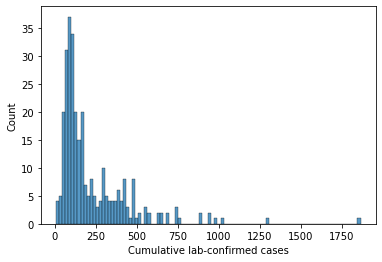

In [26]:
sns.histplot(cases_deaths_dt['Cumulative lab-confirmed cases'], bins=100)

Most subregion has number of cases between 100 and 200. The higher number of cases is above 1750.

In [27]:
cases_deaths_dt.rename(columns={'Cumulative lab-confirmed cases':'Cumulative_lab_confirmed_cases'}, inplace=True)

<a id='pm25_cases'></a>
##### Investigate the impact of particular matter with an aerodynamic diameter < 2.5 μm (pm25) on the expected number of cases

In [28]:
cases_pm25 = smf.glm(formula = "Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm25_val", data=cases_deaths_dt, family=sm.families.NegativeBinomial(alpha = 0.3669725)).fit()
print(cases_pm25.summary())
y, X = dmatrices('Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm25_val', data=cases_deaths_dt, return_type='dataframe')
vif_cases_pm25 = pd.DataFrame()
vif_cases_pm25['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_cases_pm25['variable'] = X.columns
print(vif_cases_pm25)

                       Generalized Linear Model Regression Results                        
Dep. Variable:     Cumulative_lab_confirmed_cases   No. Observations:                  295
Model:                                        GLM   Df Residuals:                      290
Model Family:                    NegativeBinomial   Df Model:                            4
Link Function:                                log   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:                -1785.4
Date:                            Fri, 01 Oct 2021   Deviance:                       310.93
Time:                                    22:31:47   Pearson chi2:                     360.
No. Iterations:                                10                                         
Covariance Type:                        nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]

All pollutants are statistically significant. Only the mean annual earnings is not a significant predictor of the number of cases. There is no collinearity

<a id='pm10_cases'></a>
##### Investigate the impact of particular matter with an aerodynamic diameter < 10.0 μm (pm10) on the expected number of cases

In [29]:
cases_pm10 = smf.glm(formula = "Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm10_val", data=cases_deaths_dt, family=sm.families.NegativeBinomial(alpha = 0.3641661)).fit()
print(cases_pm10.summary())
y, X = dmatrices('Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + pm10_val', data=cases_deaths_dt, return_type='dataframe')
vif_cases_pm10 = pd.DataFrame()
vif_cases_pm10['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_cases_pm10['variable'] = X.columns
print(vif_cases_pm10)

                       Generalized Linear Model Regression Results                        
Dep. Variable:     Cumulative_lab_confirmed_cases   No. Observations:                  295
Model:                                        GLM   Df Residuals:                      290
Model Family:                    NegativeBinomial   Df Model:                            4
Link Function:                                log   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:                -1783.9
Date:                            Fri, 01 Oct 2021   Deviance:                       310.16
Time:                                    22:31:52   Pearson chi2:                     357.
No. Iterations:                                 9                                         
Covariance Type:                        nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]

All pollutants are statistically significant. Only the mean annual earnings is not a significant predictor of the number of cases. There is no collinearity

<a id='no2_cases'></a>
##### Investigate the impact of nitrogen dioxide (no2) on the expected number of cases

In [30]:
cases_no2 = smf.glm(formula = "Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + no2_val", data=cases_deaths_dt, family=sm.families.NegativeBinomial(alpha = 0.3664346)).fit()
print(cases_no2.summary())
y, X = dmatrices('Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + no2_val', data=cases_deaths_dt, return_type='dataframe')
vif_cases_no2 = pd.DataFrame()
vif_cases_no2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_cases_no2['variable'] = X.columns
print(vif_cases_no2)

                       Generalized Linear Model Regression Results                        
Dep. Variable:     Cumulative_lab_confirmed_cases   No. Observations:                  295
Model:                                        GLM   Df Residuals:                      290
Model Family:                    NegativeBinomial   Df Model:                            4
Link Function:                                log   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:                -1786.1
Date:                            Fri, 01 Oct 2021   Deviance:                       312.70
Time:                                    22:31:55   Pearson chi2:                     424.
No. Iterations:                                10                                         
Covariance Type:                        nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]

All pollutants are statistically significant. Only the mean annual earnings is not a significant predictor of the number of cases. There is no collinearity

<a id='nox_cases'></a>
##### Investigate the impact of nitrogen oxide (nox) on the expected number of cases

In [31]:
cases_nox = smf.glm(formula = "Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + nox_val", data=cases_deaths_dt, family=sm.families.NegativeBinomial(alpha = 0.3673769)).fit()
print(cases_nox.summary())
y, X = dmatrices('Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + nox_val', data=cases_deaths_dt, return_type='dataframe')
vif_cases_nox = pd.DataFrame()
vif_cases_nox['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_cases_nox['variable'] = X.columns
print(vif_cases_nox)

                       Generalized Linear Model Regression Results                        
Dep. Variable:     Cumulative_lab_confirmed_cases   No. Observations:                  295
Model:                                        GLM   Df Residuals:                      290
Model Family:                    NegativeBinomial   Df Model:                            4
Link Function:                                log   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:                -1786.4
Date:                            Fri, 01 Oct 2021   Deviance:                       312.61
Time:                                    22:31:57   Pearson chi2:                     419.
No. Iterations:                                 9                                         
Covariance Type:                        nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]

All pollutants are statistically significant. Only the mean annual earnings is not a significant predictor of the number of cases. There is no collinearity

<a id='o3_cases'></a>
##### Investigate the impact of ozone (o3) on the expected number of cases

In [32]:
cases_o3 = smf.glm(formula = "Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + o3_val", data=cases_deaths_dt, family=sm.families.NegativeBinomial(alpha = 0.3561254)).fit()
print(cases_o3.summary())
y, X = dmatrices('Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + o3_val', data=cases_deaths_dt, return_type='dataframe')
vif_cases_o3 = pd.DataFrame()
vif_cases_o3['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_cases_o3['variable'] = X.columns
print(vif_cases_o3)

                       Generalized Linear Model Regression Results                        
Dep. Variable:     Cumulative_lab_confirmed_cases   No. Observations:                  295
Model:                                        GLM   Df Residuals:                      290
Model Family:                    NegativeBinomial   Df Model:                            4
Link Function:                                log   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:                -1780.8
Date:                            Fri, 01 Oct 2021   Deviance:                       310.87
Time:                                    22:31:59   Pearson chi2:                     372.
No. Iterations:                                 9                                         
Covariance Type:                        nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]

All pollutants are statistically significant. Only the mean annual earnings is not a significant predictor of the number of cases. There is no collinearity

<a id='so2_cases'></a>
##### Investigate the impact of solfure dioxide (so2) on the expected number of cases

In [33]:
cases_so2 = smf.glm(formula = "Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + so2_val", data=cases_deaths_dt, family=sm.families.NegativeBinomial(alpha = 0.368053)).fit()
print(cases_so2.summary())
y, X = dmatrices('Cumulative_lab_confirmed_cases ~ X2018_people_per_sq_km + Mean_ann_earnings + median_age_2018 + so2_val', data=cases_deaths_dt, return_type='dataframe')
vif_cases_o3 = pd.DataFrame()
vif_cases_o3['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_cases_o3['variable'] = X.columns
print(vif_cases_o3)

                       Generalized Linear Model Regression Results                        
Dep. Variable:     Cumulative_lab_confirmed_cases   No. Observations:                  295
Model:                                        GLM   Df Residuals:                      290
Model Family:                    NegativeBinomial   Df Model:                            4
Link Function:                                log   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:                -1785.7
Date:                            Fri, 01 Oct 2021   Deviance:                       310.60
Time:                                    22:32:01   Pearson chi2:                     416.
No. Iterations:                                 8                                         
Covariance Type:                        nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]

All pollutants are statistically significant. Only the mean annual earnings is not a significant predictor of the number of cases. There is no collinearity

The computed models are saved in a html file:

In [34]:
nb2018_cases = Stargazer([cases_pm25, cases_pm10, cases_nox, cases_no2, cases_o3, cases_so2])
nb2018_cases.custom_columns(['pm10', 'pm25', 'nox', 'no2', 'o3', 'so2'], [1,1,1,1,1,1])
html = open("../data_out/negative_binomial_cases_2018.html","w")
html.write(nb2018_cases.render_html())
html.close()

<a id='or_cases'></a>
##### Infectivity rate: compute and visualize odds ratio

In [35]:
cases_pm10_or = pd.concat([np.exp(cases_pm10.params),np.exp(cases_pm10.conf_int()[0]),np.exp(cases_pm10.conf_int()[1]),cases_pm10.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_o3_or = pd.concat([np.exp(cases_o3.params),np.exp(cases_o3.conf_int()[0]),np.exp(cases_o3.conf_int()[1]),cases_o3.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_no2_or = pd.concat([np.exp(cases_no2.params),np.exp(cases_no2.conf_int()[0]),np.exp(cases_no2.conf_int()[1]),cases_no2.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_nox_or = pd.concat([np.exp(cases_nox.params),np.exp(cases_nox.conf_int()[0]),np.exp(cases_nox.conf_int()[1]),cases_nox.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_pm25_or = pd.concat([np.exp(cases_pm25.params),np.exp(cases_pm25.conf_int()[0]),np.exp(cases_pm25.conf_int()[1]),cases_pm25.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
LA_covid_cases_onlyPoll = pd.concat([cases_pm10_or.iloc[cases_pm10_or.shape[0]-1],
                               cases_o3_or.iloc[cases_o3_or.shape[0]-1],
                               cases_no2_or.iloc[cases_no2_or.shape[0]-1],
                               cases_nox_or.iloc[cases_nox_or.shape[0]-1],
                               cases_pm25_or.iloc[cases_pm25_or.shape[0]-1]], axis=1)
LA_covid_cases_onlyPoll = LA_covid_cases_onlyPoll.transpose()
LA_covid_cases_onlyPoll['significance'] = np.where(LA_covid_cases_onlyPoll['pvalue'] < 0.05, 'p-value < 0.05', 'p-value > 0.05')
LA_covid_cases_onlyPoll['names'] = LA_covid_cases_onlyPoll.index.values 
LA_covid_cases_onlyPoll = LA_covid_cases_onlyPoll.sort_values(by=['or'], ascending = False)
LA_covid_cases_onlyPoll.to_csv("../data_out/LA_covid_CASES_onlyPoll_preL_AP2018.csv")
LA_covid_cases_onlyPoll

,or,0.025,0.975,pvalue,significance,names
no2_val,1.030513,1.011777,1.049596,0.001325,p-value < 0.05,no2_val
nox_val,1.017699,1.006812,1.028703,0.001388,p-value < 0.05,nox_val
o3_val,0.947484,0.926838,0.968590,0.000002,p-value < 0.05,o3_val
pm10_val,0.932624,0.901639,0.964673,0.000052,p-value < 0.05,pm10_val
pm25_val,0.906438,0.859458,0.955986,0.000297,p-value < 0.05,pm25_val


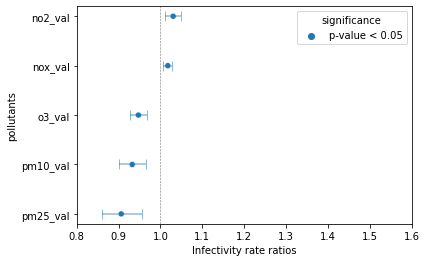

In [36]:
ax = sns.scatterplot(x="or", y="names", data=LA_covid_cases_onlyPoll, hue="significance")
plt.xlim(0.8, 1.6)
plt.axvline(x=1,linestyle ="--", linewidth=0.6, color = 'gray')
plt.xlabel("Infectivity rate ratios")
plt.ylabel("pollutants")
xerr = [abs(LA_covid_cases_onlyPoll['or'].values-LA_covid_cases_onlyPoll['0.025'].values),abs(LA_covid_cases_onlyPoll['or'].values-LA_covid_cases_onlyPoll['0.975'].values)]
plt.errorbar(LA_covid_cases_onlyPoll['or'], LA_covid_cases_onlyPoll['names'], xerr = xerr, fmt = 'none', capsize=5, alpha=0.5)
plt.savefig('../data_out/infectivity_rate_2018.png')
plt.show()

<a id='nbf_5y'></a>
### Fit negative binomial with averaged air poullution data for the years 2014-2018 with number of deaths as dependent variable

To determine the effect of spatial-temporal variations in air pollution exposure in England, the temporal scale of the analysis is increased to include temporally averaged air pollution date for the years 2014-2018.

##### Create the dataset with the average values for all the pollutants

Starting from [single year datasets](../Data/datasets.ipynb#no2_5y) (one for each year from 2014 to 2018) the values of no2 are collected and merged in the new dataset no2_5y. The average value over the 5 years is then computed and added to the dataset. Eventually, only the subregion code, the no2 value in 2018 and mean value of no2 over 2014-2018 are kept

In [37]:
no2_2014 = pd.read_csv("%s/raw_mapno22014.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'no22014'])
no2_2015 = pd.read_csv("%s/raw_mapno22015.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'no22015'])
no2_2016 = pd.read_csv("%s/raw_mapno22016.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'no22016'])
no2_2017 = pd.read_csv("%s/raw_mapno22017.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'no22017'])
no2_2018 = pd.read_csv("%s/raw_mapno22018.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'no22018'])
all_data = [no2_2014, no2_2015, no2_2016, no2_2017, no2_2018]
no2_5y = reduce(lambda left,right: pd.merge(left,right,on='ukgridcode'), all_data)
no2_5y['no2_5yAvg'] = ((no2_2014.no22014+no2_2015.no22015+no2_2016.no22016+no2_2017.no22017+no2_2018.no22018)/5)
no2_5y = no2_5y[['ukgridcode', 'no22018', 'no2_5yAvg']]
no2_5y.head()

,ukgridcode,no22018,no2_5yAvg
0,54291,NaN,NaN
1,54292,NaN,NaN
2,54294,NaN,NaN
3,54979,NaN,NaN
4,54980,NaN,NaN


Starting from [single year datasets](../Data/datasets.ipynb#no2_5y) (one for each year from 2014 to 2018) the values of nox are collected and merged in the new dataset nox_5y. The average value over the 5 years is then computed and added to the dataset. Eventually, only the subregion code, the nox value in 2018 and mean value of nox over 2014-2018 are kept

In [40]:
nox_2014 = pd.read_csv("%s/raw_mapnox2014.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'nox2014'])
nox_2015 = pd.read_csv("%s/raw_mapnox2015.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'nox2015'])
nox_2016 = pd.read_csv("%s/raw_mapnox2016.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'nox2016'])
nox_2017 = pd.read_csv("%s/raw_mapnox2017.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'nox2017'])
nox_2018 = pd.read_csv("%s/raw_mapnox2018.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'nox2018'])
all_data = [nox_2014, nox_2015, nox_2016, nox_2017, nox_2018]
nox_5y = reduce(lambda left,right: pd.merge(left,right,on='ukgridcode'), all_data)
nox_5y['nox_5yAvg'] = ((nox_2014.nox2014+nox_2015.nox2015+nox_2016.nox2016+nox_2017.nox2017+nox_2018.nox2018)/5)
nox_5y = nox_5y[['ukgridcode', 'nox2018', 'nox_5yAvg']]
nox_5y.head()

,ukgridcode,nox2018,nox_5yAvg
0,54291,NaN,NaN
1,54292,NaN,NaN
2,54294,NaN,NaN
3,54979,NaN,NaN
4,54980,NaN,NaN


Starting from [single year datasets](../Data/datasets.ipynb#no2_5y) (one for each year from 2014 to 2018) the values of pm25 are collected and merged in the new dataset pm25_5y. The average value over the 5 years is then computed and added to the dataset. Eventually, only the subregion code, the pm25 value in 2018 and mean value of pm25 over 2014-2018 are kept

In [42]:
pm25_2014 = pd.read_csv("%s/raw_mappm252014.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm252014g'])
pm25_2015 = pd.read_csv("%s/raw_mappm252015.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm252015g'])
pm25_2016 = pd.read_csv("%s/raw_mappm252016.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm252016g'])
pm25_2017 = pd.read_csv("%s/raw_mappm252017.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm252017g'])
pm25_2018 = pd.read_csv("%s/raw_mappm252018.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm252018g'])
all_data = [pm25_2014, pm25_2015, pm25_2016, pm25_2017, pm25_2018]
pm25_5y = reduce(lambda left,right: pd.merge(left,right,on='ukgridcode'), all_data)
pm25_5y['pm25_5yAvg'] = ((pm25_2014.pm252014g+pm25_2015.pm252015g+pm25_2016.pm252016g+pm25_2017.pm252017g+pm25_2018.pm252018g)/5)
pm25_5y = pm25_5y[['ukgridcode', 'pm252018g', 'pm25_5yAvg']]
pm25_5y.head()

,ukgridcode,pm252018g,pm25_5yAvg
0,54291,NaN,NaN
1,54292,NaN,NaN
2,54294,NaN,NaN
3,54979,NaN,NaN
4,54980,NaN,NaN


Starting from [single year datasets](../Data/datasets.ipynb#no2_5y) (one for each year from 2014 to 2018) the values of pm10 are collected and merged in the new dataset pm10_5y. The average value over the 5 years is then computed and added to the dataset. Eventually, only the subregion code, the pm10 value in 2018 and mean value of pm10 over 2014-2018 are kept

In [44]:
pm10_2014 = pd.read_csv("%s/raw_mappm102014.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm102014g'])
pm10_2015 = pd.read_csv("%s/raw_mappm102015.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm102015g'])
pm10_2016 = pd.read_csv("%s/raw_mappm102016.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm102016g'])
pm10_2017 = pd.read_csv("%s/raw_mappm102017.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm102017g'])
pm10_2018 = pd.read_csv("%s/raw_mappm102018.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'pm102018g'])
all_data = [pm10_2014, pm10_2015, pm10_2016, pm10_2017, pm10_2018]
pm10_5y = reduce(lambda left,right: pd.merge(left,right,on='ukgridcode'), all_data)
pm10_5y['pm10_5yAvg'] = ((pm10_2014.pm102014g+pm10_2015.pm102015g+pm10_2016.pm102016g+pm10_2017.pm102017g+pm10_2018.pm102018g)/5)
pm10_5y = pm10_5y[['ukgridcode', 'pm102018g', 'pm10_5yAvg']]
pm10_5y.head()

,ukgridcode,pm102018g,pm10_5yAvg
0,54291,NaN,NaN
1,54292,NaN,NaN
2,54294,NaN,NaN
3,54979,NaN,NaN
4,54980,NaN,NaN


Starting from [single year datasets](../Data/datasets.ipynb#no2_5y) (one for each year from 2014 to 2018) the values of o3 are collected and merged in the new dataset o3_5y. The average value over the 5 years is then computed and added to the dataset. Eventually, only the subregion code, the o3 value in 2018 and mean value of o3 over 2014-2018 are kept

In [45]:
o3_2014 = pd.read_csv("%s/raw_mapo312014.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'dgt12014'])
o3_2015 = pd.read_csv("%s/raw_mapo312015.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'dgt12015'])
o3_2016 = pd.read_csv("%s/raw_mapo312016.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'dgt12016'])
o3_2017 = pd.read_csv("%s/raw_mapo32017.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'dgt12017'])
o3_2018 = pd.read_csv("%s/raw_mapo312018.csv" %path, skiprows = 5, na_values="MISSING", usecols=['ukgridcode', 'dgt12018'])
o3_5y = reduce(lambda left,right: pd.merge(left,right,on='ukgridcode'), [o3_2014, o3_2015, o3_2016, o3_2017, o3_2018])
o3_5y['o3_5yAvg'] = ((o3_2014.dgt12014+o3_2015.dgt12015+o3_2016.dgt12016+o3_2017.dgt12017+o3_2018.dgt12018)/5)
o3_5y = o3_5y[['ukgridcode', 'dgt12018', 'o3_5yAvg']]
o3_5y.head()

,ukgridcode,dgt12018,o3_5yAvg
0,54291,NaN,NaN
1,54292,NaN,NaN
2,54294,NaN,NaN
3,54979,NaN,NaN
4,54980,NaN,NaN


All the pollutant_5y are merged in the final dataset ap_dt that contains information about all pollutants.
The ap_dt dataset is then saved as csv

In [28]:
ap_dt = reduce(lambda left,right: pd.merge(left,right,on='ukgridcode'), [no2_5y, nox_5y, o3_5y, pm10_5y, pm25_5y])
ap_dt.dropna(inplace=True)
ap_dt.to_csv("../data_out/5Yaverage_AP_PCMdata.csv")
ap_dt.head()

,ukgridcode,no22018,no2_5yAvg,nox2018,nox_5yAvg,dgt12018,o3_5yAvg,pm102018g,pm10_5yAvg,pm252018g,pm25_5yAvg
14,55671,1.734648,2.954160,2.110115,3.785750,4.699172,1.328225,4.874836,7.458620,2.994053,4.116575
24,56360,1.748184,2.955865,2.126862,3.787582,4.701599,1.328234,4.868680,7.445010,2.988176,4.105491
25,56361,1.756501,2.966006,2.137155,3.800848,4.697112,1.327758,4.877372,7.461088,2.995678,4.118182
26,56362,1.764046,2.969145,2.146492,3.804794,4.696401,1.327611,4.878715,7.462759,2.996176,4.118773
27,56363,1.807779,2.988916,2.200650,3.829626,4.692276,1.326764,4.880319,7.464448,2.997217,4.119644


##### Create the dataset with average earnings, average age and average population density overe the years2014-2018

Import the dataset [covid_air_dt_5YA](../data_out/Output_data_des.ipynb)

In [51]:
covid_air_dt_5YA = pd.read_csv("../data_out/covid_air_dt_5YA.csv" )

The dataset avgEarnings_5ya is created by merging the [avgEarnings_2014, avgEarnings_2015, avgEarnings_2016, avgEarnings_2017, avgEarnings_2018](../Data/datasets.ipynb#avgEarnings). Na are dropped.

In [52]:
avgEarnings_2014 = pd.read_csv("%s/avgEarnings_2014.csv" %path_output, na_values = "x", usecols = ["Code","avgEarn_2014"])
avgEarnings_2014.dropna(subset = ["avgEarn_2014"], inplace=True)
avgEarnings_2015 = pd.read_csv("%s/avgEarnings_2015.csv" %path_output, na_values = "x", usecols = ["Code","avgEarn_2015"])
avgEarnings_2015.dropna(subset = ["avgEarn_2015"], inplace=True)
avgEarnings_2016 = pd.read_csv("%s/avgEarnings_2016.csv" %path_output, na_values = "x", usecols = ["Code","avgEarn_2016"])
avgEarnings_2016.dropna(subset = ["avgEarn_2016"], inplace=True)
avgEarnings_2017 = pd.read_csv("%s/avgEarnings_2017.csv" %path_output, na_values = "x", usecols = ["Code","avgEarn_2017"])
avgEarnings_2017.dropna(subset = ["avgEarn_2017"], inplace=True)
avgEarnings_2018 = pd.read_csv("%s/avgEarnings_2018.csv" %path_output, na_values = "x", usecols = ["Code","avgEarn_2018"])
avgEarnings_2018.dropna(subset = ["avgEarn_2018"], inplace=True)
all_data = [avgEarnings_2014, avgEarnings_2015, avgEarnings_2016, avgEarnings_2017, avgEarnings_2018]
avgEarnings_5ya = reduce(lambda left,right: pd.merge(left,right), all_data)
avgEarnings_5ya.head()

,Code,avgEarn_2014,avgEarn_2015,avgEarn_2016,avgEarn_2017,avgEarn_2018
0,NaN,"27,316","27,542","25,802","27,489","29,341"
1,NaN,"27,316","27,692","25,802","27,489","29,341"
2,NaN,"27,316","27,806","25,802","27,489","29,341"
3,NaN,"27,316","28,028","25,802","27,489","29,341"
4,NaN,"27,316","24,499","25,802","27,489","29,341"


Commas are dropped and column are converted into integerd. 

A new column with the mean value of earning for all the 5 years is added to the dataframe

In [53]:
avgEarnings_5ya['avgEarn_2014'] = [x.replace(',','') for x in avgEarnings_5ya['avgEarn_2014']]
avgEarnings_5ya['avgEarn_2014'] = pd.to_numeric(avgEarnings_5ya['avgEarn_2014'],errors='coerce')
avgEarnings_5ya['avgEarn_2015'] = [x.replace(',','') for x in avgEarnings_5ya['avgEarn_2015']]
avgEarnings_5ya['avgEarn_2015'] = pd.to_numeric(avgEarnings_5ya['avgEarn_2015'],errors='coerce')
avgEarnings_5ya['avgEarn_2016'] = [x.replace(',','') for x in avgEarnings_5ya['avgEarn_2016']]
avgEarnings_5ya['avgEarn_2016'] = pd.to_numeric(avgEarnings_5ya['avgEarn_2016'],errors='coerce')
avgEarnings_5ya['avgEarn_2017'] = [x.replace(',','') for x in avgEarnings_5ya['avgEarn_2017']]
avgEarnings_5ya['avgEarn_2017'] = pd.to_numeric(avgEarnings_5ya['avgEarn_2017'],errors='coerce')
avgEarnings_5ya['avgEarn_2018'] = [x.replace(',','') for x in avgEarnings_5ya['avgEarn_2018']]
avgEarnings_5ya['avgEarn_2018'] = pd.to_numeric(avgEarnings_5ya['avgEarn_2018'],errors='coerce')
avgEarnings_5ya['earnings_5ya'] = ((avgEarnings_5ya['avgEarn_2014'] + avgEarnings_5ya['avgEarn_2015'] + 
                                avgEarnings_5ya['avgEarn_2016']+ avgEarnings_5ya['avgEarn_2017'] + avgEarnings_5ya['avgEarn_2018'])/5)
avgEarnings_5ya.head()

,Code,avgEarn_2014,avgEarn_2015,avgEarn_2016,avgEarn_2017,avgEarn_2018,earnings_5ya
0,NaN,27316,27542,25802,27489,29341,27498.0
1,NaN,27316,27692,25802,27489,29341,27528.0
2,NaN,27316,27806,25802,27489,29341,27550.8
3,NaN,27316,28028,25802,27489,29341,27595.2
4,NaN,27316,24499,25802,27489,29341,26889.4


Only the subregion Code and the 5 years mean earing columns are kept

In [54]:
avgEarnings_5ya = avgEarnings_5ya[["Code", "earnings_5ya"]]
avgEarnings_5ya.head()

,Code,earnings_5ya
0,NaN,27498.0
1,NaN,27528.0
2,NaN,27550.8
3,NaN,27595.2
4,NaN,26889.4


The same information for population density and age are now requested. They are contained in [Pop_density_5ya](../Data/datasets.ipynb#Pop_density_5ya) and [age_5ya](../Data/datasets.ipynb#age_5ya).

The covariates_5ya dataset is created by merging all the informations gained about age, population density and earning for the years 2014-2018

In [55]:
Pop_density_5ya = pd.read_csv("%s/Pop_density_full_dt.csv" %path, usecols = ["Code","pop_dens_5ya"])
age_5ya = pd.read_csv("%s/age_5ya.csv" %path_output, usecols = ["Code","age_5ya"])
all_data = [avgEarnings_5ya, Pop_density_5ya, age_5ya]
covariates_5ya = reduce(lambda left,right: pd.merge(left,right), all_data)
covariates_5ya.sort_values(by="Code", inplace=True)
covariates_5ya['pop_dens_5ya'] = [x.replace(',','') for x in covariates_5ya['pop_dens_5ya']]
covariates_5ya['pop_dens_5ya'] = pd.to_numeric(covariates_5ya['pop_dens_5ya'],errors='coerce')
covariates_5ya.head()

,Code,earnings_5ya,pop_dens_5ya,age_5ya
1,E06000001,24887.4,992,41.8
2,E06000002,21543.4,2601,36.4
3,E06000003,22960.2,555,44.7
4,E06000004,24847.8,957,40.3
0,E06000005,25761.8,539,42.6


Eventually, the final dataset avg_AP_dt is created by merging the 5-years mean value of the covariates and the 5-years mean value of the pollutants. 

In [56]:
merged_covid_air_dt_5YA = pd.merge(covid_air_dt_5YA, covariates_5ya, on='Code')
merged_covid_air_dt_5YA.head()
merged_covid_air_dt_5YA.to_csv('../data_out/merged_covid_air_dt_cov_5YA.csv.csv')

##### Investigate the imapact of 5-years-mean particulate matter with aerodynamic diamter <2.5 μm (pm25) on the expected number of deaths

In [57]:
pm25_deaths_5YA_nb  = smf.glm(formula = "deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + pm25_5yAvg", data=merged_covid_air_dt_5YA, family=sm.families.NegativeBinomial(alpha = 0.448833)).fit()
print(pm25_deaths_5YA_nb .summary())
y, X = dmatrices("deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + pm25_5yAvg", data=merged_covid_air_dt_5YA, return_type='dataframe')
vif_deaths_5y_pm25 = pd.DataFrame()
vif_deaths_5y_pm25['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_pm25['variable'] = X.columns
print(vif_deaths_5y_pm25)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  312
Model:                            GLM   Df Residuals:                      307
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1419.5
Date:                Fri, 01 Oct 2021   Deviance:                       340.50
Time:                        22:43:04   Pearson chi2:                     391.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.2459      0.647     11.197   

pm25_5yAvg is not statistically significant and neither earnings_5ya. There is no collinearity.

##### Investigate the imapact of 5-years-mean particulate matter with aerodynamic diamter <10.0 μm (pm10) on the expected number of deaths

In [58]:
pm10_deaths_5YA_nb  = smf.glm(formula = "deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + pm10_5yAvg", data=merged_covid_air_dt_5YA, family=sm.families.NegativeBinomial(alpha = 0.4490346)).fit()
print(pm10_deaths_5YA_nb .summary())
y, X = dmatrices("deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + pm10_5yAvg", data=merged_covid_air_dt_5YA, return_type='dataframe')
vif_deaths_5y_pm10 = pd.DataFrame()
vif_deaths_5y_pm10['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_pm10['variable'] = X.columns
print(vif_deaths_5y_pm10)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  312
Model:                            GLM   Df Residuals:                      307
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1419.0
Date:                Fri, 01 Oct 2021   Deviance:                       339.30
Time:                        22:43:06   Pearson chi2:                     388.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.3023      0.618     11.818   

pm10_5yAvg is not statistically significant and neither earnings_5ya. There is no collinearity.

##### Investigate the imapact of 5-years-mean nitrogen oxide (nox) on the expected number of deaths

In [59]:
nox_deaths_5YA_nb  = smf.glm(formula = "deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + nox_5yAvg", data=merged_covid_air_dt_5YA, family=sm.families.NegativeBinomial(alpha = 0.4290004)).fit()
print(nox_deaths_5YA_nb .summary())
y, X = dmatrices("deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + nox_5yAvg", data=merged_covid_air_dt_5YA, return_type='dataframe')
vif_deaths_5y_nox = pd.DataFrame()
vif_deaths_5y_nox['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_nox['variable'] = X.columns
print(vif_deaths_5y_nox)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  312
Model:                            GLM   Df Residuals:                      307
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1416.4
Date:                Fri, 01 Oct 2021   Deviance:                       348.15
Time:                        22:43:08   Pearson chi2:                     429.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7041      0.563     10.127   

nox_5yAvg is a significant predictor for the expected number of deaths and it is a risk factor. There is no collinearity

##### Investigate the imapact of 5-years-mean nitrogen dioxide (no2) on the expected number of deaths

In [60]:
no2_deaths_5YA_nb  = smf.glm(formula = "deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + no2_5yAvg", data=merged_covid_air_dt_5YA, family=sm.families.NegativeBinomial(alpha = 0.4295533)).fit()
print(no2_deaths_5YA_nb .summary())
y, X = dmatrices("deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + no2_5yAvg", data=merged_covid_air_dt_5YA, return_type='dataframe')
vif_deaths_5y_no2 = pd.DataFrame()
vif_deaths_5y_no2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_no2['variable'] = X.columns
print(vif_deaths_5y_no2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  312
Model:                            GLM   Df Residuals:                      307
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1416.2
Date:                Fri, 01 Oct 2021   Deviance:                       347.30
Time:                        22:43:11   Pearson chi2:                     433.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.5630      0.593      9.374   

no2_5yAvg is a significant predictor for the expected number of deaths and it is a risk factor. There is no collinearity

##### Investigate the imapact of 5-years-mean ozone (o3) on the expected number of deaths

In [61]:
o3_deaths_5YA_nb  = smf.glm(formula = "deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + o3_5yAvg", data=merged_covid_air_dt_5YA, family=sm.families.NegativeBinomial(alpha = 0.4249894)).fit()
print(o3_deaths_5YA_nb .summary())
y, X = dmatrices("deaths ~ pop_dens_5ya + earnings_5ya + age_5ya + o3_5yAvg", data=merged_covid_air_dt_5YA, return_type='dataframe')
vif_deaths_5y_o3 = pd.DataFrame()
vif_deaths_5y_o3['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_o3['variable'] = X.columns
print(vif_deaths_5y_o3)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 deaths   No. Observations:                  312
Model:                            GLM   Df Residuals:                      307
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1411.9
Date:                Fri, 01 Oct 2021   Deviance:                       341.92
Time:                        22:43:13   Pearson chi2:                     394.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.4723      0.501     12.922   

o3_5yAvg is a significant predictor for the expected number of deaths and it is a proective factor. There is no collinearity

##### Mortality rate: compute and visualize odds ratio

In [62]:
deaths_pm10_5Y_or = pd.concat([np.exp(pm10_deaths_5YA_nb.params),np.exp(pm10_deaths_5YA_nb.conf_int()[0]),
                               np.exp(pm10_deaths_5YA_nb.conf_int()[1]),pm10_deaths_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_o3_5Y_or = pd.concat([np.exp(o3_deaths_5YA_nb.params),np.exp(o3_deaths_5YA_nb.conf_int()[0]),
                             np.exp(o3_deaths_5YA_nb.conf_int()[1]),o3_deaths_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_no2_5Y_or = pd.concat([np.exp(no2_deaths_5YA_nb.params),np.exp(no2_deaths_5YA_nb.conf_int()[0]),
                              np.exp(no2_deaths_5YA_nb.conf_int()[1]),no2_deaths_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_nox_5Y_or = pd.concat([np.exp(nox_deaths_5YA_nb.params),np.exp(nox_deaths_5YA_nb.conf_int()[0]),
                              np.exp(nox_deaths_5YA_nb.conf_int()[1]),nox_deaths_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
deaths_pm25_5Y_or = pd.concat([np.exp(pm25_deaths_5YA_nb.params),np.exp(pm25_deaths_5YA_nb.conf_int()[0]),
                               np.exp(pm25_deaths_5YA_nb.conf_int()[1]),pm25_deaths_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])


In [63]:
LA_covid_DEATHS_onlyPoll_5YA = pd.concat([deaths_pm10_5Y_or.iloc[deaths_pm10_5Y_or.shape[0]-1],
                               deaths_o3_5Y_or.iloc[deaths_o3_5Y_or.shape[0]-1],
                               deaths_no2_5Y_or.iloc[deaths_no2_5Y_or.shape[0]-1],
                               deaths_nox_5Y_or.iloc[deaths_nox_5Y_or.shape[0]-1],
                               deaths_pm25_5Y_or.iloc[deaths_pm25_5Y_or.shape[0]-1]], axis=1)
LA_covid_DEATHS_onlyPoll_5YA = LA_covid_DEATHS_onlyPoll_5YA.transpose()
LA_covid_DEATHS_onlyPoll_5YA['names'] = LA_covid_DEATHS_onlyPoll_5YA.index.values 
LA_covid_DEATHS_onlyPoll_5YA['significance'] = np.where(LA_covid_DEATHS_onlyPoll_5YA['pvalue'] < 0.05, 'p-value < 0.05', 'p-value > 0.05')
LA_covid_DEATHS_onlyPoll_5YA = LA_covid_DEATHS_onlyPoll_5YA.sort_values(by=['or'], ascending = False)
LA_covid_DEATHS_onlyPoll_5YA.to_csv("../data_out/LA_covid_DEATHS_onlyPoll_5YA.csv")
LA_covid_DEATHS_onlyPoll_5YA

,or,0.025,0.975,pvalue,names,significance
no2_5yAvg,1.024696,1.007714,1.041966,0.004221,no2_5yAvg,p-value < 0.05
nox_5yAvg,1.014038,1.004445,1.023723,0.004048,nox_5yAvg,p-value < 0.05
pm10_5yAvg,0.962899,0.924020,1.003415,0.072199,pm10_5yAvg,p-value > 0.05
pm25_5yAvg,0.954196,0.895956,1.016222,0.144517,pm25_5yAvg,p-value > 0.05
o3_5yAvg,0.827422,0.758175,0.902993,0.000022,o3_5yAvg,p-value < 0.05


From the table we can conclude that pm_25 and pm_10 are not significant predictors for the number of deaths, while no2, nox and o3 have a significant impact.

For a unit increase of nitrogen oxide, the expected number of deaths increases by 1.4%.
For a unit incraese od nitrogen dioxide, the expected number of deaths increases by 2.4%.
For a unit increase of ozone, the expected number of deaths decreases by 16.5%

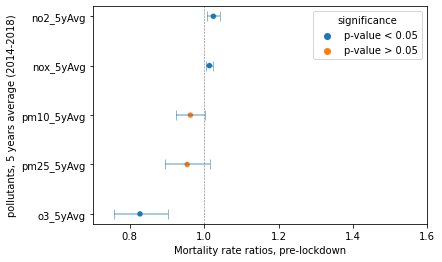

In [64]:
ax = sns.scatterplot(x="or", y="names", data=LA_covid_DEATHS_onlyPoll_5YA, hue="significance")
plt.xlim(0.7, 1.6)
plt.axvline(x=1,linestyle ="--", linewidth=0.6, color = 'gray')
plt.xlabel("Mortality rate ratios, pre-lockdown")
plt.ylabel("pollutants, 5 years average (2014-2018)")
xerr = [abs(LA_covid_DEATHS_onlyPoll_5YA['or'].values-LA_covid_DEATHS_onlyPoll_5YA['0.025'].values),
        abs(LA_covid_DEATHS_onlyPoll_5YA['or'].values-LA_covid_DEATHS_onlyPoll_5YA['0.975'].values)]
plt.errorbar(LA_covid_DEATHS_onlyPoll_5YA['or'], LA_covid_DEATHS_onlyPoll_5YA['names'], xerr = xerr, fmt = 'none', capsize=5, alpha=0.5)
plt.savefig('../data_out/mortality_rate_avg.png')

<a id='nbf_cases_5y'></a>
### Fit negative binomial with averaged air poullution data for the years 2014-2018 with number of cases as dependent variable

Import the dataset with data related to cases [cases_LA_raw]('..Data/datasets.ipynb#cases_LA_raw'). From this dataset we're interested only in date with speciment date in April 10. The variable of interest is 'cumulative la-vonfirmed cases'.

We want to have the mean cases per area code.

In [65]:
cases_LA_raw = pd.read_csv("%s/coronavirus-cases_latest-18_5_2020.csv" %path)
cases_LA_dt = cases_LA_raw.loc[cases_LA_raw["Specimen date"]== "2020-04-10",["Area code", "Cumulative lab-confirmed cases"]]
cases_LA_dt = cases_LA_dt.groupby(['Area code']).mean()
cases_LA_dt.head()

,Cumulative lab-confirmed cases
Area code,
E06000001,79
E06000002,272
E06000003,158
E06000004,199
E06000005,125


Now a new dataset is created by merging the cases_LA_dt (with cases) and the covid_air_dt_5YA (with deaths) and then saved as csv

In [66]:
cases_deaths_5YA = pd.merge(merged_covid_air_dt_5YA,cases_LA_dt, left_on='Code', right_on='Area code').drop_duplicates()
cases_deaths_5YA.to_csv("../data_out/cases_deaths_5YA.csv")
cases_deaths_5YA.rename(columns={'Cumulative lab-confirmed cases':'cases'}, inplace=True)
cases_deaths_5YA.head()

,Code,deaths,2018 people per sq. km,Mean_ann_earnings,median_age_2018,pm25_5yAvg,no2_5yAvg,o3_5yAvg,pm10_5yAvg,nox_5yAvg,earnings_5ya,pop_dens_5ya,age_5ya,cases
0,E06000001,20,997,25985.0,41.8,7.617911,14.359226,2.811139,11.625293,20.206839,24887.4,992,41.8,79
1,E06000002,60,2608,22878.0,36.2,8.342286,20.537654,2.240947,12.522083,30.628743,21543.4,2601,36.4,272
2,E06000003,26,558,23236.0,45.0,7.748073,8.440613,3.795747,12.845976,11.273612,22960.2,555,44.7,158
3,E06000004,26,962,26622.0,40.4,8.038180,16.408541,2.670293,12.169144,23.435383,24847.8,957,40.3,199
4,E06000005,14,540,26908.0,43.1,7.368713,12.552451,2.763806,11.199639,17.361185,25761.8,539,42.6,125


##### Investigate the imapact of 5-years-mean particulate matter with aerodynamic diamter <2.5 μm (pm25) on the expected number of cases

In [67]:
pm25_cases_5YA_nb = smf.glm(formula = "cases ~ pop_dens_5ya + earnings_5ya + age_5ya + pm25_5yAvg", data = cases_deaths_5YA, family=sm.families.NegativeBinomial(alpha = 0.3963535)).fit()
print(pm25_cases_5YA_nb.summary())
y, X = dmatrices("cases ~ pop_dens_5ya + earnings_5ya + age_5ya + pm25_5yAvg", data=cases_deaths_5YA, return_type='dataframe')
vif_deaths_5y_pm25 = pd.DataFrame()
vif_deaths_5y_pm25['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_pm25['variable'] = X.columns
print(vif_deaths_5y_pm25)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                  283
Model:                            GLM   Df Residuals:                      278
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1721.7
Date:                Fri, 01 Oct 2021   Deviance:                       278.22
Time:                        22:43:28   Pearson chi2:                     324.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.0547      0.636     15.813   

pm25 is significant with a protective effect. There is no collinearity

In [68]:
pm10_cases_5YA_nb = smf.glm(formula = "cases ~ pop_dens_5ya + earnings_5ya + age_5ya + pm10_5yAvg", data = cases_deaths_5YA, family=sm.families.NegativeBinomial(alpha=0.39)).fit()
print(pm10_cases_5YA_nb.summary())
y, X = dmatrices("cases ~ pop_dens_5ya + earnings_5ya + age_5ya + pm10_5yAvg", data=cases_deaths_5YA, return_type='dataframe')
vif_deaths_5y_pm10 = pd.DataFrame()
vif_deaths_5y_pm10['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_pm10['variable'] = X.columns
print(vif_deaths_5y_pm10)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                  283
Model:                            GLM   Df Residuals:                      278
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1720.5
Date:                Fri, 01 Oct 2021   Deviance:                       280.47
Time:                        22:43:29   Pearson chi2:                     324.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.9502      0.596     16.699   

pm10 is significant with a protective effect. There is no collinearity

In [69]:
nox_cases_5YA_nb = smf.glm(formula = "cases ~ pop_dens_5ya + earnings_5ya + age_5ya + nox_5yAvg", data = cases_deaths_5YA, family=sm.families.NegativeBinomial(alpha=0.39)).fit()
print(nox_cases_5YA_nb.summary())
y, X = dmatrices("cases ~ pop_dens_5ya + earnings_5ya + age_5ya + nox_5yAvg", data=cases_deaths_5YA, return_type='dataframe')
vif_deaths_5y_nox = pd.DataFrame()
vif_deaths_5y_nox['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_nox['variable'] = X.columns
print(vif_deaths_5y_nox)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                  283
Model:                            GLM   Df Residuals:                      278
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1724.3
Date:                Fri, 01 Oct 2021   Deviance:                       288.23
Time:                        22:43:31   Pearson chi2:                     384.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.4130      0.564     13.139   

nox is a significative risk factor. There is no collinearity

In [70]:
no2_cases_5YA_nb = smf.glm(formula = "cases ~ pop_dens_5ya + earnings_5ya + age_5ya + no2_5yAvg", data = cases_deaths_5YA, family=sm.families.NegativeBinomial(alpha=0.39)).fit()
print(no2_cases_5YA_nb.summary())
y, X = dmatrices("cases ~ pop_dens_5ya + earnings_5ya + age_5ya + no2_5yAvg", data=cases_deaths_5YA, return_type='dataframe')
vif_deaths_5y_no2 = pd.DataFrame()
vif_deaths_5y_no2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_no2['variable'] = X.columns
print(vif_deaths_5y_no2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                  283
Model:                            GLM   Df Residuals:                      278
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1724.3
Date:                Fri, 01 Oct 2021   Deviance:                       288.23
Time:                        22:43:34   Pearson chi2:                     387.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.2488      0.603     12.031   

In [71]:
o3_cases_5YA_nb = smf.glm(formula = "cases ~ pop_dens_5ya + earnings_5ya + age_5ya + o3_5yAvg", data = cases_deaths_5YA, family=sm.families.NegativeBinomial(alpha=0.39)).fit()
print(o3_cases_5YA_nb.summary())
y, X = dmatrices("cases ~ pop_dens_5ya + earnings_5ya + age_5ya + o3_5yAvg", data=cases_deaths_5YA, return_type='dataframe')
vif_deaths_5y_o3 = pd.DataFrame()
vif_deaths_5y_o3['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_deaths_5y_o3['variable'] = X.columns
print(vif_deaths_5y_o3)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                  283
Model:                            GLM   Df Residuals:                      278
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1710.3
Date:                Fri, 01 Oct 2021   Deviance:                       260.22
Time:                        22:43:35   Pearson chi2:                     313.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.1759      0.487     16.775   

In [72]:
cases_pm10_5Y_or = pd.concat([np.exp(pm10_cases_5YA_nb.params),np.exp(pm10_cases_5YA_nb.conf_int()[0]),
                               np.exp(pm10_cases_5YA_nb.conf_int()[1]),pm10_cases_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_o3_5Y_or = pd.concat([np.exp(o3_cases_5YA_nb.params),np.exp(o3_cases_5YA_nb.conf_int()[0]),
                             np.exp(o3_cases_5YA_nb.conf_int()[1]),o3_cases_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_no2_5Y_or = pd.concat([np.exp(no2_cases_5YA_nb.params),np.exp(no2_cases_5YA_nb.conf_int()[0]),
                              np.exp(no2_cases_5YA_nb.conf_int()[1]),no2_cases_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_nox_5Y_or = pd.concat([np.exp(nox_cases_5YA_nb.params),np.exp(nox_cases_5YA_nb.conf_int()[0]),
                              np.exp(nox_cases_5YA_nb.conf_int()[1]),nox_cases_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])
cases_pm25_5Y_or = pd.concat([np.exp(pm25_cases_5YA_nb.params),np.exp(pm25_cases_5YA_nb.conf_int()[0]),
                               np.exp(pm25_cases_5YA_nb.conf_int()[1]),pm25_cases_5YA_nb.pvalues], axis=1,
                       keys=['or', '0.025', '0.975', 'pvalue'])

In [102]:
LA_covid_cases_onlyPoll_5YA = pd.concat([cases_pm10_5Y_or.iloc[cases_pm10_5Y_or.shape[0]-1],
                               cases_o3_5Y_or.iloc[cases_o3_5Y_or.shape[0]-1],
                               cases_no2_5Y_or.iloc[cases_no2_5Y_or.shape[0]-1],
                               cases_nox_5Y_or.iloc[cases_nox_5Y_or.shape[0]-1],
                               cases_pm25_5Y_or.iloc[cases_pm25_5Y_or.shape[0]-1]], axis=1)
LA_covid_cases_onlyPoll_5YA = LA_covid_cases_onlyPoll_5YA.transpose()
LA_covid_cases_onlyPoll_5YA['names'] = LA_covid_cases_onlyPoll_5YA.index.values 
LA_covid_cases_onlyPoll_5YA['significance'] = np.where(LA_covid_cases_onlyPoll_5YA['pvalue'] < 0.05, 'p-value < 0.05', 'p-value > 0.05')
LA_covid_cases_onlyPoll_5YA = LA_covid_cases_onlyPoll_5YA.sort_values(by=['or'], ascending = False)
#LA_covid_cases_onlyPoll_5YA.to_csv("../data_out/LA_covid_cases_onlyPoll_5YA.csv.csv")
LA_covid_cases_onlyPoll_5YA

,or,0.025,0.975,pvalue,names,significance
no2_5yAvg,1.026130,1.008407,1.044166,3.711532e-03,no2_5yAvg,p-value < 0.05
nox_5yAvg,1.014934,1.005084,1.024881,2.890467e-03,nox_5yAvg,p-value < 0.05
pm10_5yAvg,0.917919,0.881246,0.956117,3.835612e-05,pm10_5yAvg,p-value < 0.05
pm25_5yAvg,0.884735,0.830475,0.942541,1.491242e-04,pm25_5yAvg,p-value < 0.05
o3_5yAvg,0.772175,0.709183,0.840763,2.604744e-09,o3_5yAvg,p-value < 0.05


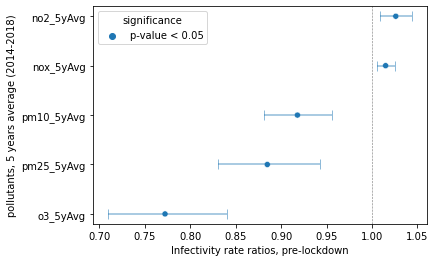

In [75]:
ax = sns.scatterplot(x="or", y="names", data=LA_covid_cases_onlyPoll_5YA, hue="significance")
plt.axvline(x=1,linestyle ="--", linewidth=0.6, color = 'gray')
plt.xlabel("Infectivity rate ratios, pre-lockdown")
plt.ylabel("pollutants, 5 years average (2014-2018)")
xerr = [abs(LA_covid_cases_onlyPoll_5YA['or'].values-LA_covid_cases_onlyPoll_5YA['0.025'].values),
        abs(LA_covid_cases_onlyPoll_5YA['or'].values-LA_covid_cases_onlyPoll_5YA['0.975'].values)]
plt.errorbar(LA_covid_cases_onlyPoll_5YA['or'], LA_covid_cases_onlyPoll_5YA['names'], xerr = xerr, fmt = 'none', capsize=5, alpha=0.5)
plt.savefig('../data_out/infectivity_rate_avg.png')